# DFT and/vs LSTM for time series prediction

## DFT

### Theory recap

Note: 
- We'll only deal with Real valued signals
- We'll use torch as we'll deal with LSTMs later, but the commands for numpy and scipy are almost identical.
- We'll set the sample rate `fs=1`

First let's review some things that we need to know about the Discrete Fourier Transform (DFT)

**1) FFT stands for Fast Fourier Transform and is the `O(nlog(n))` algorithm typically used to compute the DFT.**

Hence torch.fftm numpy.fft, scipy.fft.

**2) The DFT is a linear operation that maps a signal of N samples onto N complex values which represent the amplitudes and phases of the harmonics/components that make up the signal.**

The frequencies of these components are determined by `N` and the sample rate `fs`: `f[k]=k*fs/N`, or simply `f[k]=k/N` in our case.

**3) While there are N components in the DFT, these only correspond to about `N/2` different and unique fundamental frequencies.**

That is becasue the DFT maps the signal onto a given positive frequency and its negative separately. The two are functionally equivalent and when dealing with real valued signals the two corresponding amplitueds are added together and we just work with the positive frequency.

Specifically we have,

if N is even:
- `N/2`  positive frequency components, including the DC component (the constant value/offset of the signal). 
- `1` value for the Nyquist component `fs/2` (the highest possible frequency) 
- So `N/2+1` in total.

The frequencies will be `f = [0, 1/N, 2/N, ..., 1/2]`

The periods will be     `T = [0, N, N/2, ..., 2]`

if N is odd:
- `(N+1)/2`  positive frequency components including the DC component.
-  Note that we don't reach the Nyquist component in this case, the highest frequency component in the DFT will be slightly below it.

The frequencies will be `f = [0, 1/N, 2/N, ..., 1/2 - 1/2N]`

The periods will be     `T = [0, N, N/2, ..., 2N/(N-1)]`


Let's explore the above in torch and see if we get what we expect.

In [9]:
import torch
# Even N
print("EVEN")
N = 16
expected_components = N/2 + 1
y = torch.arange(N)
dft = torch.fft.rfft(y)
assert int(expected_components) == len(dft)
print(len(dft), expected_components, dft.dtype)

f = torch.fft.rfftfreq(N)
T = 1/torch.fft.rfftfreq(N)
T[0]=0
print(f)
print(T)

# Odd N
print("ODD")
N=15
expected_components = (N+1)/2
y = torch.arange(N)
dft = torch.fft.rfft(y)
assert int(expected_components) == len(dft)
print(len(dft), expected_components, dft.dtype)

f = torch.fft.rfftfreq(N)
T = 1/torch.fft.rfftfreq(N)
T[0]=0
print(f)
print(T)


EVEN
9 9.0 torch.complex64
tensor([0.0000, 0.0625, 0.1250, 0.1875, 0.2500, 0.3125, 0.3750, 0.4375, 0.5000])
tensor([ 0.0000, 16.0000,  8.0000,  5.3333,  4.0000,  3.2000,  2.6667,  2.2857,
         2.0000])
ODD
8 8.0 torch.complex64
tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667])
tensor([ 0.0000, 15.0000,  7.5000,  5.0000,  3.7500,  3.0000,  2.5000,  2.1429])


To get the corresponding aplitudes we do:

In [10]:
amplitudes = torch.abs(dft) / N # Scale by N to retieve the actual valued of the amplitudes of the harmonics
phases = torch.angle(dft)
print(len(amplitudes), amplitudes)
print(len(phases), phases)

8 tensor([7.0000, 2.4049, 1.2293, 0.8507, 0.6728, 0.5774, 0.5257, 0.5028])
8 tensor([0.0000, 1.7802, 1.9897, 2.1991, 2.4086, 2.6180, 2.8274, 3.0369])


### Exploration: DFT in pratice

Let's familiarize whith how the DFT works in practice.

While obtaining values for the amplitudes, pahses, frequencies etc...is intersting it doe snto help much in understadning.
What is more helpful is to understand the opposite direction of how the frequencies come together to build the signal and predict the signal beyond the sampling window.

So we will do `signal -> dft -> mess with the dft -> see how well the signal is reconstructed inside and outside the sampling window. `

Let's define some helper functions.

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import wandb
from pathlib import Path

np.random.seed(0)  # Seed for reproducibility

def generate_signal(num_samples=200, noise=False, num_components=(3, 7), periods_range=(2, 200)):
    """
    :param num_samples: Total number of samples in the signal
    :return: 
    """        
    if type(num_components) == int:
        num_components = (num_components, num_components+1)
    else:
        assert num_components[0] < num_components[1]
    if type(periods_range) == int:
        periods_range = (periods_range, periods_range+1)
    else:
        assert periods_range[0] <= periods_range[1]

    num_components = np.random.randint(*num_components)  # Randomly choose how many periods to combine
    
    periods = np.random.randint(*periods_range, num_components)  # Period lengths in samples
    phases = np.random.rand(num_components) * 2 * np.pi
    amplitudes = np.random.rand(num_components)
    amplitudes /= np.sum(amplitudes)

    # Sample indices
    samples = np.arange(num_samples)

    # Generate a random continuous periodic signal
    signal = sum(amplitude * np.sin(2 * np.pi * (1 / period) * samples + phase) for amplitude, period, phase in zip(amplitudes, periods, phases))
    signal = signal / np.max(np.abs(signal))  # Normalize signal

    # Add random noise to the signal
    if noise:
        noise = np.random.normal(0, 0.1, signal.shape)
        signal += noise
        signal = signal / np.max(np.abs(signal))  # Normalize signal again

    return torch.from_numpy(samples), torch.from_numpy(signal)



def get_fft_harmonics(orignal_signal, analysis_samples, hamming_smoothing=False):
    if hamming_smoothing:
        signal_window = orignal_signal[:analysis_samples]
        window = torch.hamming_window(analysis_samples, periodic=False)
        signal_window = signal_window * window
        fft_result = torch.fft.rfft(signal_window)
    else:
        fft_result = torch.fft.rfft(orignal_signal[:analysis_samples])
    amplitudes = torch.abs(fft_result) / analysis_samples
    phases = torch.angle(fft_result)
    
    # Double the amplitudes for non-DC components
    # Note: The last component should not be doubled if N is even and represents the Nyquist frequency
    if analysis_samples % 2 == 0:
        # If the original signal length is even, don't double the last component (Nyquist frequency)
        amplitudes[1: -1] *= 2
    else:
        # If the original signal length is odd, all components except the DC can be doubled
        amplitudes[1:] *= 2
    return amplitudes, phases

def get_signal_from_harmonics(amplitudes, phases, num_samples):
    analysis_samples = len(amplitudes) * 2 - 2  # Adjust for rfft output length
    reconstructed_signal = torch.zeros(num_samples, dtype=torch.complex64)
    for index, (amplitude, phase) in enumerate(zip(amplitudes, phases)):
        reconstructed_signal += amplitude * torch.exp(1j * (2 * torch.pi * index * torch.arange(num_samples) / analysis_samples + phase))

    # Return the real part of the reconstructed signal
    return reconstructed_signal.real


def reconstruct_signal_fft(orignal_signal, analysis_samples, hamming_smoothing=False):
    # Perform FFT on the entire signal
    amplitudes, phases = get_fft_harmonics(orignal_signal, analysis_samples, hamming_smoothing)

    # Return the real part of the reconstructed signal
    return get_signal_from_harmonics(amplitudes, phases, len(orignal_signal))


We can use `generate_signal` to produce a random signal. We can get a non radom output for just one compoentn with a specified periodicity.

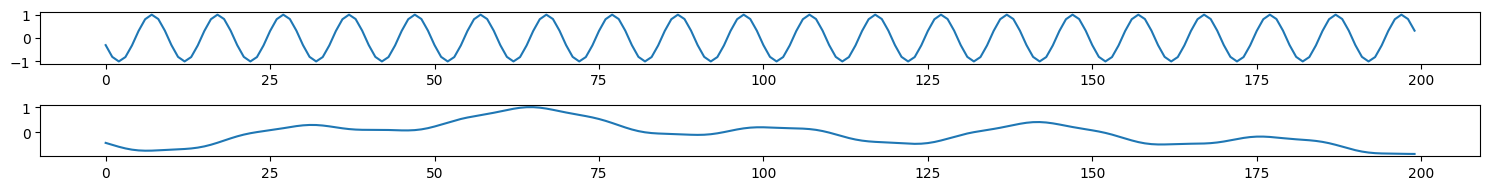

In [121]:
plt.figure(figsize=(15, 2))

plt.subplot(2, 1, 1)
# signal with 1 component with a period of 10 samples
x,y  = generate_signal(num_components=1, periods_range=10)
plt.plot(x,y)
plt.subplot(2, 1, 2)
# signal with a random amount of components and periods
x,y  = generate_signal()
plt.plot(x,y)

plt.tight_layout()
plt.show()



Let's now define a function that takes care of plotting the original signal, the reconstructed signal and the amplitudes and phases of the harmonics.

In [122]:

def plot_signal_and_fft(signal: torch.Tensor, train_test_split_idx: int, hamming_smoothing: bool = False):
    assert (W := signal.shape[0]) >= train_test_split_idx
    t_full = torch.arange(W)


    amplitudes, phases = get_fft_harmonics(signal, train_test_split_idx, hamming_smoothing)
    frequency_bins = np.arange(len(amplitudes), dtype=np.float16)

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    plt.plot(t_full, signal, label="original")
    plt.plot(t_full, get_signal_from_harmonics(amplitudes, phases, W), '-x', label="fft reconstruction")
    plt.axvspan(0, train_test_split_idx-1, color='grey', alpha=0.3)
    plt.xlabel('t [samples]')
    plt.legend(loc='best')
    plt.title('Signal')
    
    fft_frequencies = frequency_bins/train_test_split_idx
    plt.subplot(1, 3, 2)
    plt.xscale('log')
    plt.plot(fft_frequencies, amplitudes)
    plt.xlabel('Frequency [1/samples]')
    plt.title('Amplitudes')

    fft_periods = frequency_bins.copy()
    fft_periods[1:]=train_test_split_idx/fft_periods[1:]
    plt.subplot(1, 3, 3)
    plt.plot(frequency_bins, amplitudes)
    top_5_indices = np.argsort(amplitudes)[-4:]
    top_5_indices[0]=1
    plt.xscale('log')
    plt.xticks(frequency_bins[top_5_indices],fft_periods[top_5_indices], rotation=70)
    plt.xlabel('T [samples]')
    plt.title('Amplitudes')


    plt.tight_layout()
    plt.show()



Now let's start applying the DFT to 1 component and see how we do.
Let's generate 200 samples and do the DFT on the first 100.

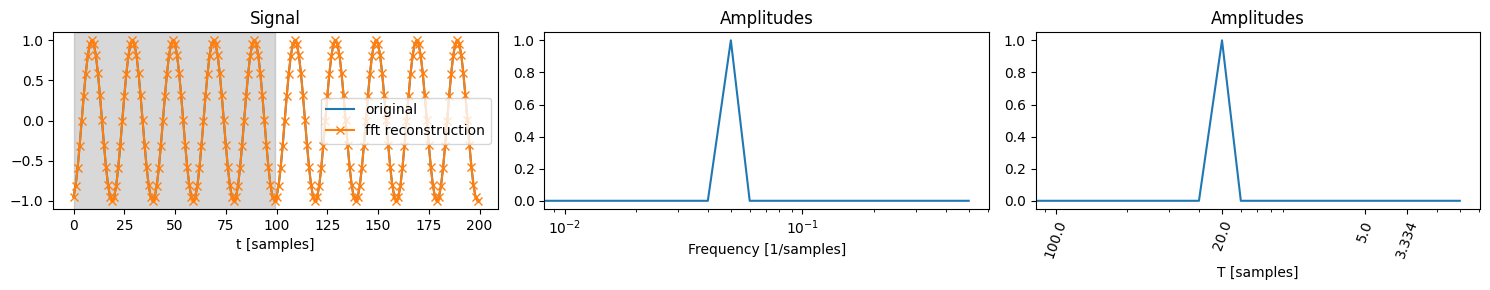

In [124]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 100)

Perfection! The DFT correctyl detects that we have 1 harmonic with a period of 20 samples, and our reconstruction then of course is also spot on outside of th fist 100 samples we did the DFT on.

We tried on 100 samples, then 110 samples must be even better! Let's try.

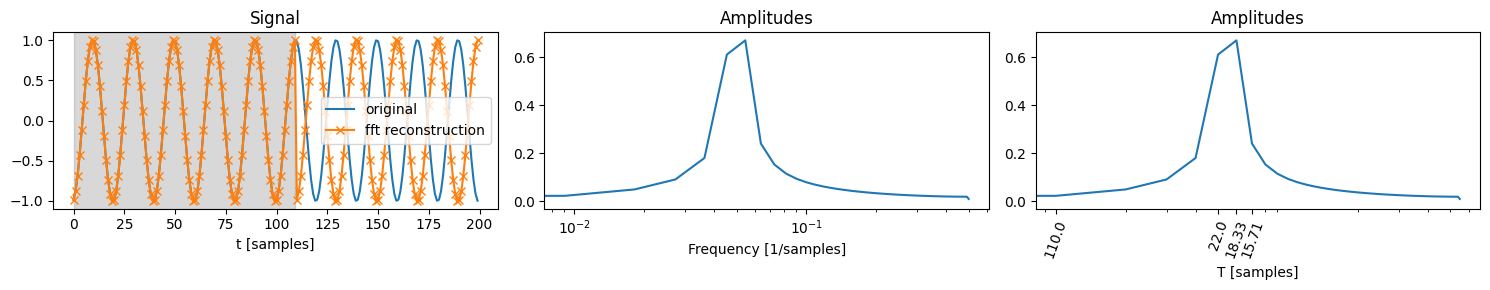

In [125]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 110)

Ouch that is not what one could have hoped for. Why?

**Becasue the DFT "assumes" that all components have a periodicity that completes an integer number of cycles within the sampling window.**

But a sinusoid with a period of 20 does not complete an integre number of cycles in 120 samples. Teh consequence is that the power of the signal get's spread out a bit over more frequencies (amplitude peak is not perfectly narrow on 20). This is known as spectral lekage.

Moreover our "prediction" of the signal outside the sampling window becomes terrible, as the reconstructed signal is just a copy of  the signal inside the sampling window. This is exactly what the DFT assumes: that the sample window we provide it is exactly the period of the signal (up to an integer factor)!

One way to reduce spectral leakage is having smoothing of the signal at the edges of the sampling window towards 0. 

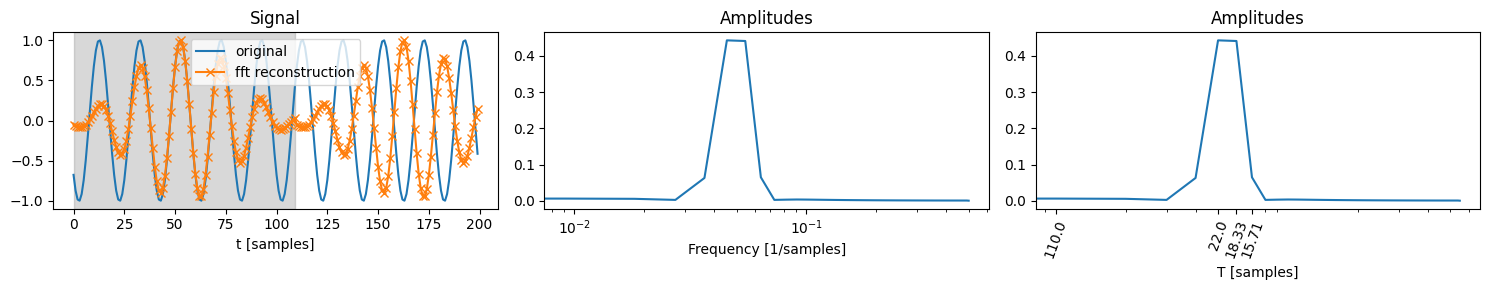

In [131]:
_, y = generate_signal(num_components=1, periods_range=20)
plot_signal_and_fft(y, 110, hamming_smoothing=True)

This localizes the amplitude peak a bit more, but it certianly doesn't help with the predicitve qualities of out reconstruction

Before we move on let's just look at the DFT of a more complex signal.

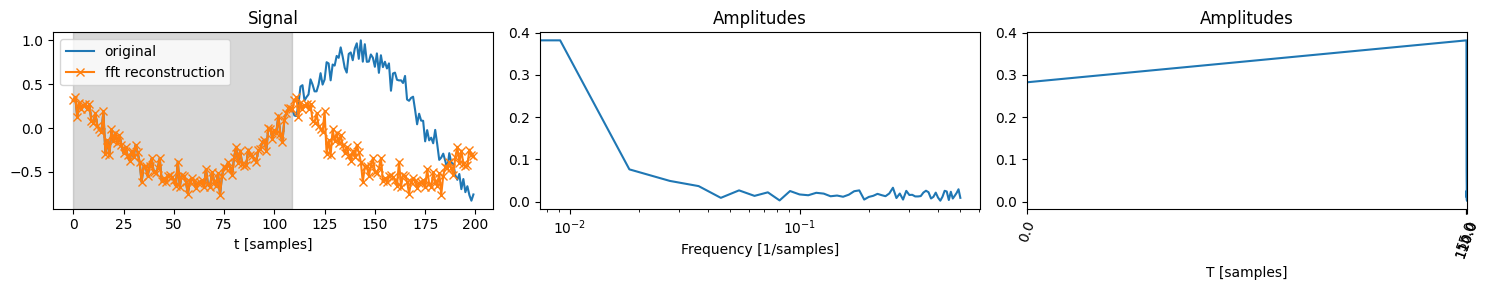

In [133]:
_, y = generate_signal(200, noise=True)
plot_signal_and_fft(y, 110)

###  With Real data

768


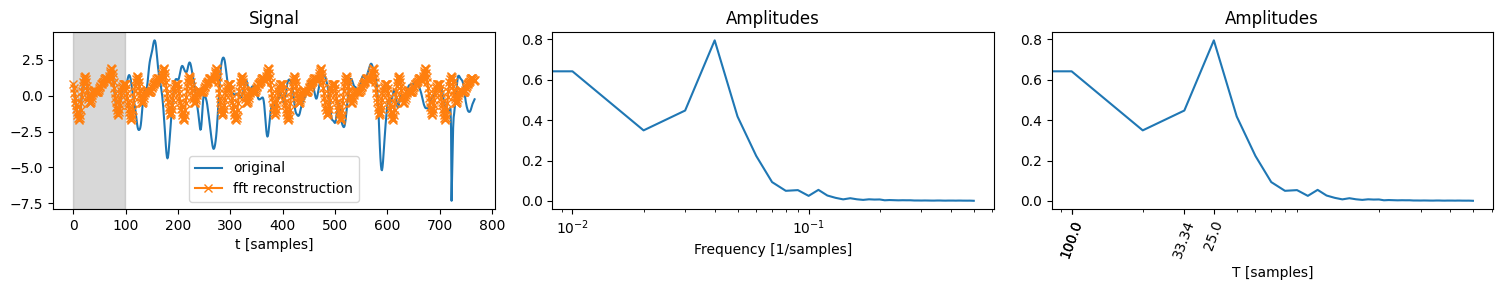

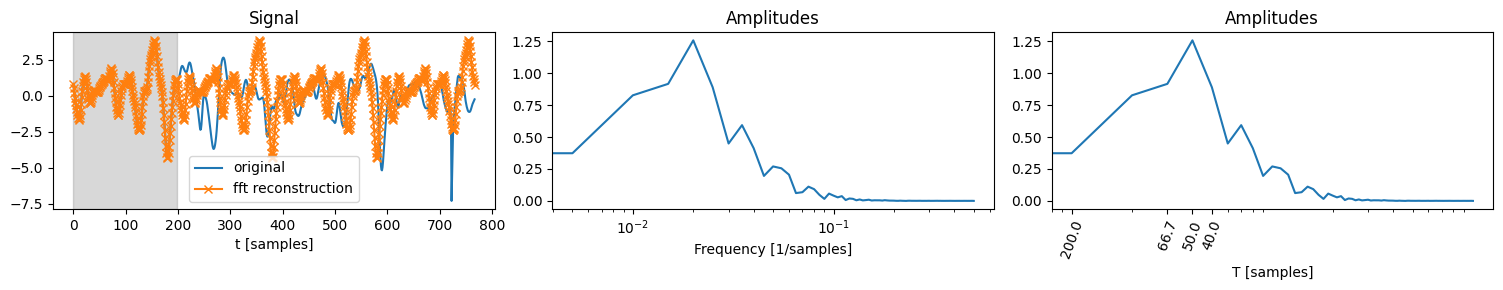

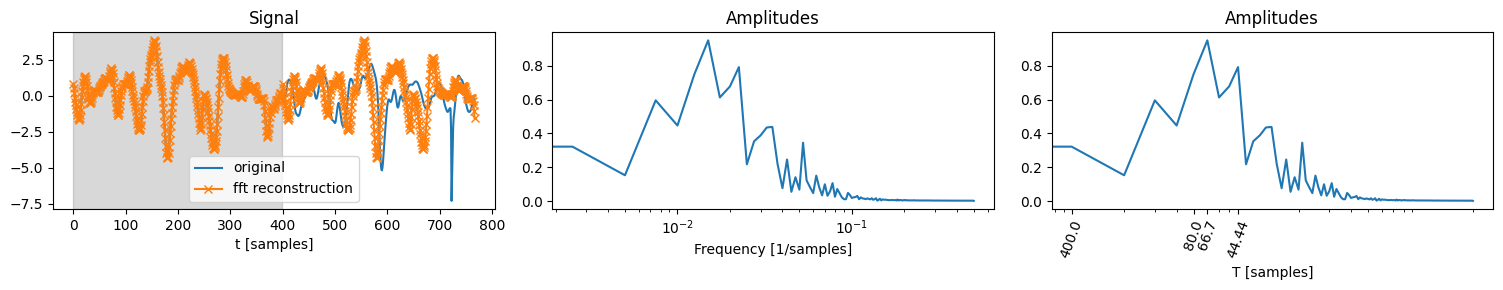

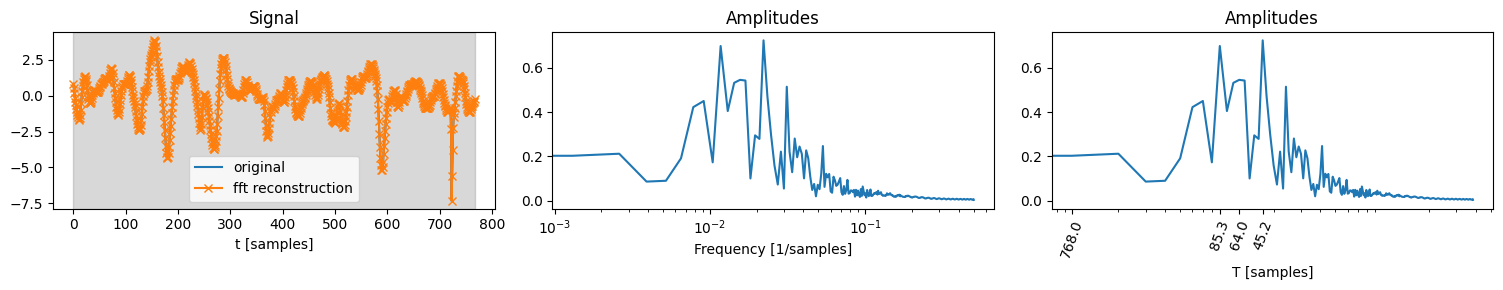

In [99]:
import pandas as pd
import torch

# Replace 'your_file.csv' with the path to your CSV file
# and 'your_column_name' with the name of the column you want to read.
csv_file = './data/data_easier.csv'
column_name = 'target'

# Read the CSV file using pandas
df = pd.read_csv(csv_file)

# Select the column and convert it to a NumPy array
column_data = df[column_name].to_numpy()

# Convert the NumPy array to a PyTorch tensor
targets = torch.tensor(column_data, dtype=torch.float32)  # or torch.float64 for double precision
targets = targets-torch.mean(targets)
print(len(targets))
plot_signal_and_fft(targets, 100)
plot_signal_and_fft(targets, 200)
plot_signal_and_fft(targets, 400)
plot_signal_and_fft(targets, len(targets))

## LSTM

We have looked at how a DFT alone can help us in predicting oiur signals and the anser is, not very well.
So let's see how a very simple LSTM performs.

In [3]:
class SignalDataset(Dataset):
    def __init__(self, size):
        """
        :param size: Number of samples in the dataset
        """
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, signal = generate_signal()
        # print("__getitem__")
        # Convert to PyTorch tensors
        signal = torch.tensor(signal, dtype=torch.float)
        target = torch.roll(signal, -1, dims=0)
        return signal.unsqueeze_(dim=-1), target.unsqueeze_(dim=-1)

In [4]:

class LSTMPredictor(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size, batch_first=True, num_layers=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_1 = torch.nn.Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.linear_2 = torch.nn.Linear(int(hidden_layer_size/2), output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x =  self.leaky_relu(x)
        x = self.linear_1(x)
        x = self.leaky_relu(x)
        x = self.linear_2(x)
        return x


In [5]:
# Nicer summary of model
def count_parameters(model):
    from prettytable import PrettyTable
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = LSTMPredictor()

pram_count = count_parameters(model)
LR = 0.002
device =  torch.device("cpu") if torch.backends.mps.is_available() else torch.device("cpu")
print("DEVICE", device)
model.to(device)

checkpoint_path = './checkpoints/m4sf3o8e/2000_epochs_m4sf3o8e'
# checkpoint_path = None

if checkpoint_path:
    checkpoint_data = checkpoint_path.split("/")[-1].split("_")
    start_epochs = int(checkpoint_data[0])
else:
    start_epochs = 0


+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| lstm.weight_ih_l0 |    800     |
| lstm.weight_hh_l0 |   160000   |
|  lstm.bias_ih_l0  |    800     |
|  lstm.bias_hh_l0  |    800     |
| lstm.weight_ih_l1 |   160000   |
| lstm.weight_hh_l1 |   160000   |
|  lstm.bias_ih_l1  |    800     |
|  lstm.bias_hh_l1  |    800     |
|  linear_1.weight  |   20000    |
|   linear_1.bias   |    100     |
|  linear_2.weight  |    100     |
|   linear_2.bias   |     1      |
+-------------------+------------+
Total Trainable Params: 504201
DEVICE cpu


In [34]:
common_kwargs={
    'project':"time-series",
    'tags': [f"lr_{LR}", f"params_{pram_count}"],
    'name':'harmonic-signal-prediction-lstm',
}
if checkpoint_path:
    wandb_id = checkpoint_data[-1]
    model.load_state_dict(torch.load(checkpoint_path))

    wandb.init(
        **common_kwargs,
        id=wandb_id,
        resume=True
    )
else:
    wandb.init(
        **common_kwargs
    )

In [39]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
dataset = SignalDataset(size=1000) 
val_dataset = SignalDataset(size=1000)  
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
epochs = 2001


for i in range(start_epochs, start_epochs + epochs + 1):
    model.train()
    train_loss = 0
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq.to(device))
        single_loss = loss_function(y_pred, labels.to(device))
        single_loss.backward()
        train_loss += single_loss
        optimizer.step()

    if i % 25 == 0:
        model.eval()
        val_loss = 0
        for seq, labels in val_dataloader:
            y_pred = model(seq.to(device))
            single_loss = loss_function(y_pred, labels.to(device))
            val_loss += single_loss
        print(f'TRAIN: epoch: {i},  loss: {train_loss.item()}')
        print(f'VAL: epoch: {i},  val loss: {val_loss.item()} \n')
        wandb.log({"train loss": train_loss.item(), "val loss": val_loss.item()}, i)
        if i % 100 == 0:
            Path(f"./checkpoints/{wandb.run.id}/").mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), f'./checkpoints/{wandb.run.id}/{i}_epochs_{wandb.run.id}')
        

TRAIN: epoch: 0,  loss: 3.9175126552581787
VAL: epoch: 0,  val loss: 1.217633605003357 

TRAIN: epoch: 25,  loss: 0.6162568926811218
VAL: epoch: 25,  val loss: 0.6265370845794678 

TRAIN: epoch: 50,  loss: 0.5738358497619629
VAL: epoch: 50,  val loss: 0.5825968980789185 

TRAIN: epoch: 75,  loss: 0.5353890061378479
VAL: epoch: 75,  val loss: 0.5231268405914307 

TRAIN: epoch: 100,  loss: 0.5329431295394897
VAL: epoch: 100,  val loss: 0.5260406136512756 

TRAIN: epoch: 125,  loss: 0.5344786047935486
VAL: epoch: 125,  val loss: 0.531976580619812 

TRAIN: epoch: 150,  loss: 0.5182275772094727
VAL: epoch: 150,  val loss: 0.5091279149055481 

TRAIN: epoch: 175,  loss: 0.500478982925415
VAL: epoch: 175,  val loss: 0.5151376128196716 

TRAIN: epoch: 200,  loss: 0.5040776133537292
VAL: epoch: 200,  val loss: 0.5071827173233032 

TRAIN: epoch: 225,  loss: 0.5043283104896545
VAL: epoch: 225,  val loss: 0.5057314038276672 

TRAIN: epoch: 250,  loss: 0.5362386107444763
VAL: epoch: 250,  val loss: 

In [40]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val loss,█▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂
train loss,0.48085
val loss,0.46116


In [6]:
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

PERIDOS [ 31  30 135  86]


/var/folders/9l/khjvspfx1bg14csgvz4fpk_00000gn/T/ipykernel_61461/1536760959.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal = torch.tensor(signal, dtype=torch.float)


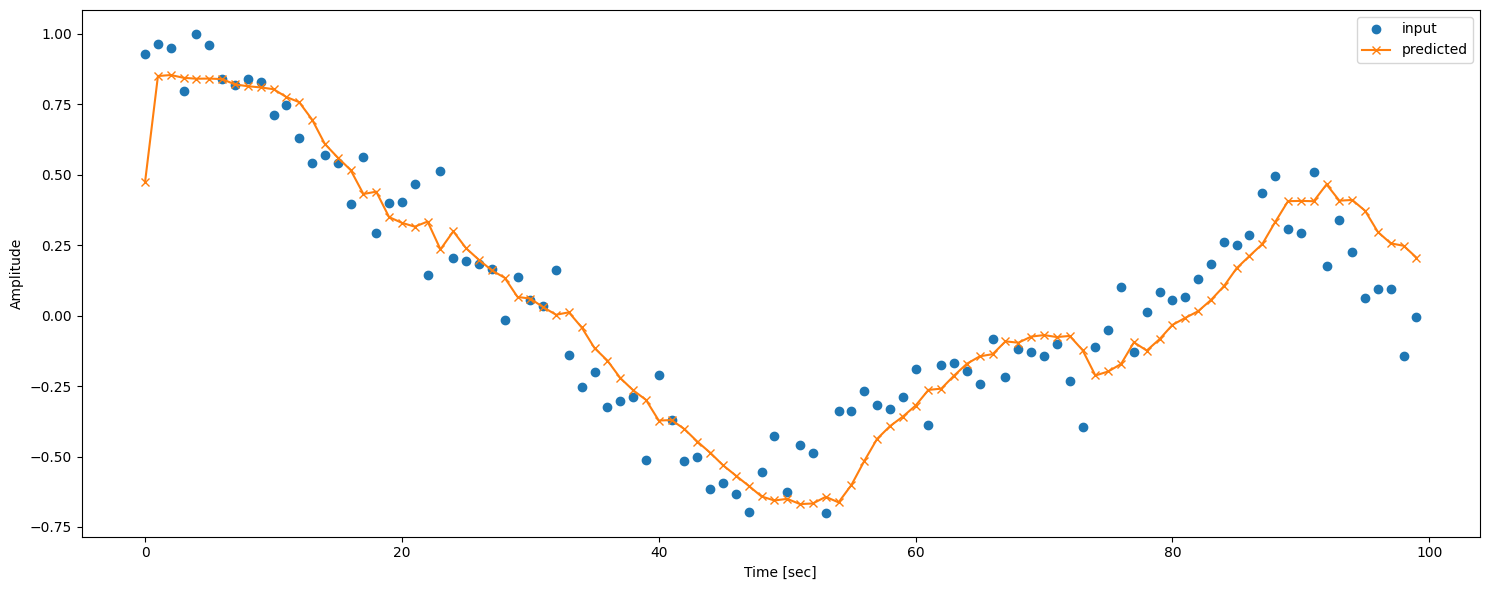

In [25]:
t, signal = generate_signal()
signal = torch.tensor(signal, dtype=torch.float)
pred = model(signal.view(1, len(signal), 1))
predicted_signal = pred.view(len(signal)).detach()
predicted_signal = torch.roll(predicted_signal, 1, dims=0)

# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal, 'o', label='input')
plt.plot(t, predicted_signal, '-x', label='predicted')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

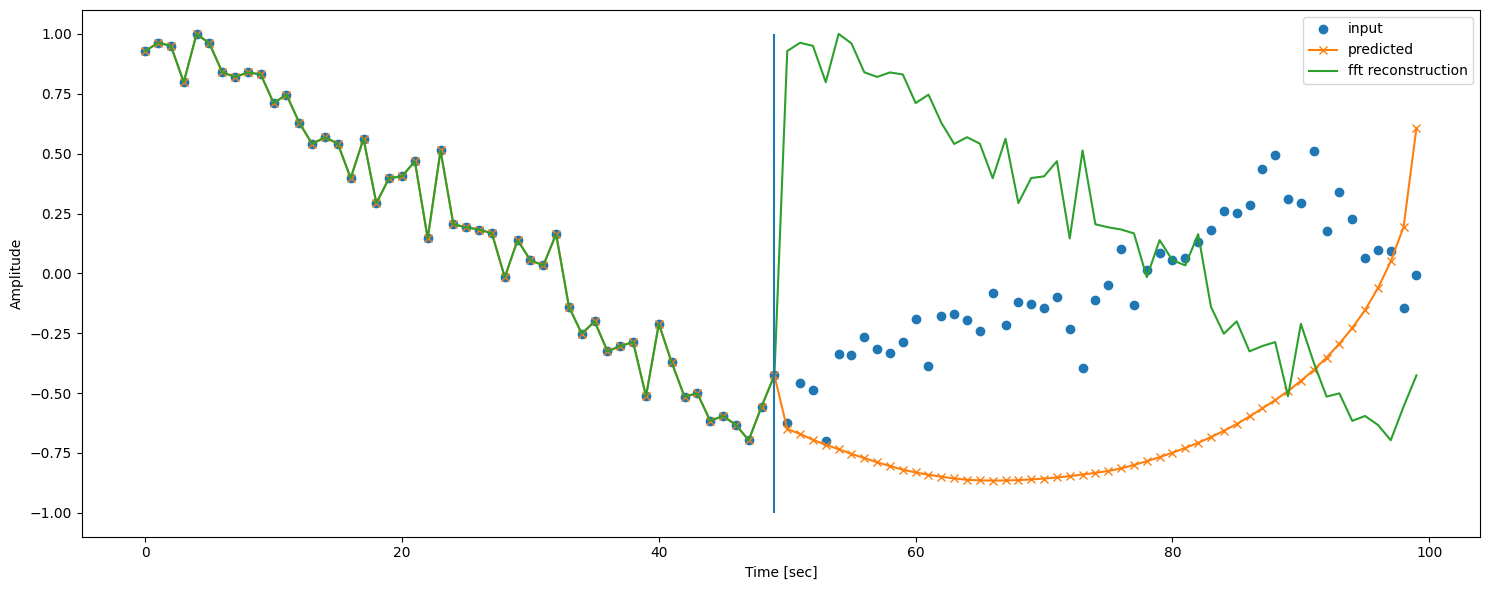

In [26]:
signal_continuation_autoreg = torch.clone(signal)
signal_continuation_autoreg[50:] = 0
for i in range(len(signal[50:])):
    pred = model(signal_continuation_autoreg.view(1, len(signal_continuation_autoreg), 1))
    pred = pred.view(len(signal_continuation_autoreg)).detach()
    signal_continuation_autoreg[50+i] = pred[50+i-1]

# Plotting
plt.figure(figsize=(15, 6))

plt.plot(t, signal, 'o', label='input')
plt.plot(t, signal_continuation_autoreg, '-x', label='predicted')
plt.plot(t, reconstruct_signal_fft(signal, 50), label='fft reconstruction')
plt.legend(loc='best')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')

plt.vlines(t[49], -1, 1)

plt.tight_layout()
plt.show()